## Try PyOD

* Basic check to see how PyOD detect anomalies

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.font_manager

### Test on Simulated Data

In [6]:
from pyod.utils.data import generate_data, get_outliers_inliers

outlier_fraction = 0.05
total_records = 200

# 5% outliers, better to set random_state, otherwise it's difficult to differentiate inliners and outliers in plot
X_train, y_train = generate_data(n_train=total_records,train_only=True, n_features=2, contamination=outlier_fraction,
                                 random_state = 10)
x_outliers, x_inliers = get_outliers_inliers(X_train, y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

print(n_inliers, n_outliers)

(190, 10)


In [7]:
print(X_train[:10])
print(y_train[:10])
print(np.unique(y_train, return_counts=True))

[[ 8.12134237  8.91658164]
 [ 9.08988677  9.35806311]
 [ 8.72853316  8.73078769]
 [ 9.13545602  8.74236303]
 [ 8.83968938  9.30961464]
 [ 8.95916181  9.0528698 ]
 [ 9.09318097  9.51839971]
 [ 8.9278589   8.69203977]
 [ 9.12710325  9.42224982]
 [ 9.13189251  8.87163196]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(array([ 0.,  1.]), array([190,  10]))


In [8]:
# 1 features
f1 = X_train[:,[0]]
f2 = X_train[:,[1]]

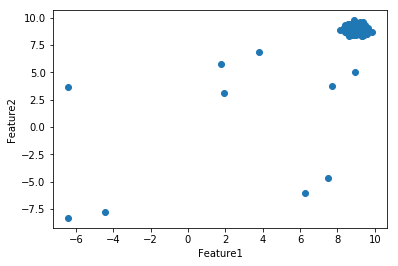

In [9]:
# The cluster at top right corner is inliners, others (10 points) are outliers
plt.scatter(f1,f2)
plt.xlabel('Feature1')
plt.ylabel('Feature2') 
plt.show()

In [12]:
# create a meshgrid 
## 200 points, the ploted meshgrid has both x-axis, y-axis in [-10, 10] range
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
xx

array([[-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       ..., 
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ]])

In [18]:
# check some data structures used below
print(xx.shape)
print(xx.ravel().shape)  # ravel() method convert 200*200 matrix into a 40000 list
xx.ravel()

(200, 200)
(40000,)


array([-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
         9.89949749,  10.        ])

In [28]:
# check some data structures used below
print(np.c_[xx.ravel(), yy.ravel()].shape)
np.c_[xx.ravel(), yy.ravel()]

(40000, 2)


array([[-10.        , -10.        ],
       [ -9.89949749, -10.        ],
       [ -9.79899497, -10.        ],
       ..., 
       [  9.79899497,  10.        ],
       [  9.89949749,  10.        ],
       [ 10.        ,  10.        ]])

In [25]:
# import models 
from pyod.models.ocsvm import OCSVM
from pyod.models.loci import LOCI
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP

random_state = 10

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

classifiers = {'One-class SVM (OCSVM)': OCSVM(contamination=outlier_fraction, random_state=random_state),
              'Local Correlation Integral (LOCI)': LOCI(contamination=outlier_fraction),
              'Stochastic Outlier Selection (SOS)': SOS(contamination=outlier_fraction),
              'Locally Selective Combination (LSCP)': LSCP(detector_list, contamination=outlier_fraction,
                                                        random_state=random_state)}

In [ ]:
# Fit the model
plt.figure(figsize=(10, 10))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(X_train)
    scores_pred = clf.decision_function(X_train) * -1  # predicted anomaly score
    y_pred = clf.predict(X_train)  # predict whether inliner or outlier
    # threshold is the specified percentile (100 * outlier_fraction) at a list of scores_pred
    threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_fraction)
    n_errors = (y_pred != y_train).sum()
    print('Number of Errors : ', clf_name, n_errors, 'Percentage of Errors: ' n_errors*100.0/total_records)

    # plot the results
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1  # predicted anomaly score for each (x,y) point
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(1, 2, i + 1)
    
    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    # inliner white dots; outlier black dots
    b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white', s=20, edgecolor='k')
    c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black', s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
    subplot.set_xlim((-7, 7))
    subplot.set_ylim((-7, 7))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
# plt.savefig('ALL.png', dpi=300)
plt.show()


(1, 'fitting', 'Local Correlation Integral (LOCI)')
('Number of Errors : ', 'Local Correlation Integral (LOCI)', 12)
